In [1]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm

# Load data

In [2]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

mnist = tf.keras.datasets.mnist
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()

X_tr = np.reshape(X_tr, [-1, 784])
X_te = np.reshape(X_te, [-1, 784])

n_three_tr, n_five_tr = sum(y_tr == 3), sum(y_tr == 5)

X_tr_35 = np.vstack([
    X_tr[y_tr == 3, :],
    X_tr[y_tr == 5, :]
]).astype(np.float32)
y_tr_35 = np.array([1] * n_three_tr + [0] * n_five_tr)

n_three_te, n_five_te = sum(y_te == 3), sum(y_te == 5)
X_te_35 = np.vstack([
    X_te[y_te == 3, :],
    X_te[y_te == 5, :]
]).astype(np.float32)
y_te_35 = np.array([1] * n_three_te + [0] * n_five_te)

X_tr_35 = X_tr_35 * (np.random.uniform(0, 1, X_tr_35.shape) > 0.8)
X_te_35 = X_te_35 * (np.random.uniform(0, 1, X_te_35.shape) > 0.8)

# Baselines

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
for model in [
                LogisticRegression(), 
                RandomForestClassifier(n_jobs=-1, n_estimators=200)
            ]:
    model.fit(X_tr_35, y_tr_35)
    predictions = model.predict(X_te_35)
    acc = accuracy_score(y_te_35, predictions)
    print('model: {}'.format(model.__str__()))
    print('accuracy: {}'.format(acc))
    print()

/Users/Tamas.Jambor@kindredgroup.com/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


model: LogisticRegression()
accuracy: 0.8932702418506835

model: RandomForestClassifier(n_estimators=200, n_jobs=-1)
accuracy: 0.8932702418506835



# Dense example

In [12]:
import sys
sys.path.append("/Users/Tamas.Jambor@kindredgroup.com/code/tffm")

In [6]:
%load_ext autoreload
%autoreload 2

In [5]:
from tffm_tf2 import TFFMClassifier

for order in [2, 3]:
    model = TFFMClassifier(
        order=order, 
        rank=10, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='dense',
        seed=42
    )
    model.fit(X_tr_35, y_tr_35, show_progress=True)
    predictions = model.predict(X_te_35)
    print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te_35, predictions)))
    # this will close tf.Session and free resources


  0%|          | 0/50 [00:00<?, ?epoch/s]

[order=2] accuracy: 0.8937960042060988


100%|██████████| 50/50 [00:30<00:00,  1.67epoch/s]

[order=3] accuracy: 0.8958990536277602


# Regression example

In [10]:
from tffm_tf2 import TFFMRegressor
from sklearn.metrics import mean_squared_error

model = TFFMRegressor(
    order=order, 
    rank=10, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
)
# translate Y from {0,1} to {-10, 10}
model.fit(X_tr_35, y_tr_35*20-10, show_progress=True)
predictions = model.predict(X_te_sparse)
print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions > 0)))
print('MSE: {}'.format(mean_squared_error(y_te*20-10, predictions)))
model.destroy()

AttributeError: 'TFFMRegressor' object has no attribute 'init_basemodel'

# n_features/time complexity

In [11]:
order = 3
model = TFFMClassifier(
    order=order, 
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=10, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    log_dir='./tmp/logs',
    verbose=1
)
model.fit(X_tr_sparse, y_tr, show_progress=True)
predictions = model.predict(X_te_sparse)
print('[order={}] accuracy: {}'.format(order, accuracy_score(y_te, predictions)))

Initialize logs, use: 
tensorboard --logdir=/Users/mikhail/std/repos/tffm/tmp/logs


100%|██████████| 10/10 [00:00<00:00, 10.79epoch/s]

[order=3] accuracy: 0.8767252195734002


# Save/load example

In [12]:
model.save_state('./tmp/state.tf')
model.destroy()

In [13]:
model = TFFMClassifier(
    order=3, 
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=10, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    log_dir='./tmp/logs',
    verbose=1
)

# internally model need to allocate memory before load previous weights,
# so need to set num_features explicitly
model.core.set_num_features(X_tr.shape[1])
model.load_state('./tmp/state.tf')

Initialize logs, use: 
tensorboard --logdir=/Users/mikhail/std/repos/tffm/tmp/logs
INFO:tensorflow:Restoring parameters from ./tmp/state.tf


# Different optimizers

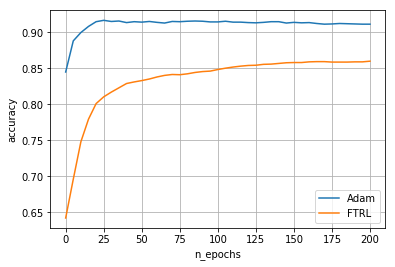

In [17]:
for optim, title in [(tf.train.AdamOptimizer(learning_rate=0.001), 'Adam'), 
              (tf.train.FtrlOptimizer(0.01, l1_regularization_strength=0.01), 'FTRL')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=optim,
        batch_size=1024,
        init_std=0.001,
        reg=0.1,
        input_type='sparse',
    )
    n_epochs = 5
    anchor_epochs = range(0, 200+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
        predictions = model.predict(X_te_sparse)
        acc.append(accuracy_score(y_te, predictions))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('accuracy')
legend()
grid()

# Different regularization strategies

In [18]:
X_all = np.vstack([
    mnist_images[mnist_labels==3,:],
    mnist_images[mnist_labels==5,:]
])

y_all = np.array([1]*n_three + [0]*n_five)

# make it more sparse (sparseness is about 97%)
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.97)

print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {}'.format(np.mean(X_all != 0)))
print('Classes balance: {} / {}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=42, test_size=0.3)

Dataset shape: (10625, 784)
Non-zeros rate: 0.006023889555822329
Classes balance: 0.46936470588235296 / 0.5306352941176471


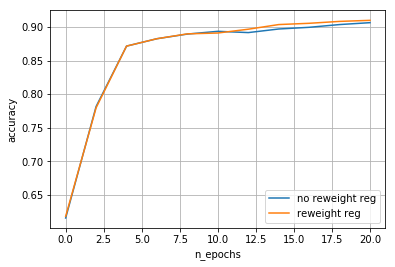

In [19]:
for use_reweight, title in [(False, 'no reweight reg'), (True, 'reweight reg')]:
    acc = []
    model = TFFMClassifier(
        order=3, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
        batch_size=1024,
        init_std=0.001,
        reg=1.0,
        input_type='sparse',
        reweight_reg = use_reweight
    )
    n_epochs = 2
    anchor_epochs = range(0, 20+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_tr_sparse, y_tr, n_epochs=n_epochs)
        predictions = model.predict(X_te_sparse)
        acc.append(accuracy_score(y_te, predictions))
    plot(anchor_epochs, acc, label=title)
    model.destroy()
xlabel('n_epochs')
ylabel('accuracy')
legend(loc=4)
grid()

# Weighted Loss Function

When using `TFFMClassifier`, one can set the parameter `sample_weights` in order to 

1. Use a "balanced" weighting scheme, in which the weight applied to the positive class is $w_+ = n_- / n_+$.
2. Prove a custom weight that is applied to every sample from the positive class.
2. Prove arbitrary weights to be applied to each sample.

We will demonstrate the first two approaches.

In [20]:
from sklearn.metrics import confusion_matrix

# generate imbalanced data:
X_imbalanced = X_all[4000:,:]
y_imbalanced = y_all[4000:]

print('Classes balance: {:.03f} / {:.03f}'.format(np.mean(y_imbalanced==0), 
                                                  np.mean(y_imbalanced==1)))

print('Balanced positive weight is {:.03f}.'.format(np.mean(y_imbalanced==0)/np.mean(y_imbalanced==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_imbalanced, y_imbalanced, random_state=42, test_size=0.3)

Classes balance: 0.753 / 0.247
Balanced positive weight is 3.045.


In [22]:
# use default weighting
model = TFFMClassifier(
    order=2,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='dense',
    seed=42
)
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()  

100%|██████████| 50/50 [00:02<00:00, 21.29epoch/s]

accuracy: 0.7494969818913481


In [23]:
confusion_matrix(y_te,predictions)

array([[1413,   56],
       [ 442,   77]])

Unweighted loss shows good performance on prevalent class, but poor performance on class with smaller representation

In [24]:
# use balanced weighting
model = TFFMClassifier(
    order=2,
    sample_weight='balanced',
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='dense',
    seed=42
)
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()

100%|██████████| 50/50 [00:02<00:00, 19.58epoch/s]

accuracy: 0.7354124748490946


In [25]:
confusion_matrix(y_te,predictions)

array([[1187,  282],
       [ 244,  275]])

Performance in underrepresented class improved, at the cost of performance in prevalent class.

In [26]:
# use manully weighting for positive class
model = TFFMClassifier(
    order=2,
    pos_class_weight=6.0,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='dense',
    seed=42
)
model.fit(X_tr, y_tr, show_progress=True)
predictions = model.predict(X_te)
print('accuracy: {}'.format(accuracy_score(y_te, predictions)))
model.destroy()  

100%|██████████| 50/50 [00:02<00:00, 20.05epoch/s]

accuracy: 0.48893360160965793


In [27]:
confusion_matrix(y_te,predictions)

array([[491, 978],
       [ 38, 481]])

Here we've overdone it, but we're quite accurate on the underrepresented class. The limiting case will cause the classifier to put all point into the over-weighted class.